# Greater Manchester Accidents Analysis

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Data Exploration

In [2]:
# Read in the data
df = pd.read_csv('/content/drive/MyDrive/Datasets/accident_data_gm_2010-2021.csv')
df.head()

,Accident Index,Year,Severity,NumberVehicles,NumberCasualties,OutputDate,Day,OutputTime,Easting,Northing,...,Road2Class,Road2Number,PedCrossingHumanControl,PedCrossingPhysicalFacilities,LightingCondition,WeatherCondition,RoadSurface,SpecialConditions,CarriagewayHazard,PlaceReported
0,102262412010,2010,3,2,1,01/01/2010,6,13:10,382347,390025,...,3,5103,0,0,1,1,4,0,0,1
1,102262562010,2010,3,2,1,01/01/2010,6,11:10,381892,390582,...,7,0,0,0,1,1,4,0,0,1
2,102264322010,2010,3,2,1,01/01/2010,6,17:30,385840,403134,...,7,0,0,0,4,1,2,0,0,2
3,107264182010,2010,3,3,1,01/01/2010,6,13:49,377762,403302,...,1,60,0,0,3,9,1,0,0,2
4,114261842010,2010,3,1,1,01/01/2010,6,01:55,355982,404620,...,0,0,0,0,7,9,1,0,0,2


In [3]:
# Check data dimension
df.shape

(45626, 27)

- The dataset contains 45,626 rows and 27 columns.

In [4]:
# Check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45626 entries, 0 to 45625
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Accident Index                 45626 non-null  int64 
 1   Year                           45626 non-null  int64 
 2   Severity                       45626 non-null  int64 
 3   NumberVehicles                 45626 non-null  int64 
 4   NumberCasualties               45626 non-null  int64 
 5   OutputDate                     45626 non-null  object
 6   Day                            45626 non-null  int64 
 7   OutputTime                     45626 non-null  object
 8   Easting                        45626 non-null  int64 
 9   Northing                       45626 non-null  int64 
 10  LocalAuthority                 45626 non-null  int64 
 11  Road1Class                     45626 non-null  int64 
 12  Road1Number                    45626 non-null  int64 
 13  C

- All the variables are of integer data type except two that are of object data type. The result also indicates that there are no missing values in the dataset.

In [6]:
# Check duplicate data
df.duplicated().sum()

0

- The result shows that there are no duplicate values in the dataset.

### Feature Engineering
In the cell below, we will extract the hour of the day from the 'OutputTime' column in order to carry out analysis of accidents by hour of the day in Manchester.

In [ ]:
# Extract hour of the day from the OutputTime column
df['hour'] = pd.to_datetime(df['OutputTime'], format="%H:%M").dt.hour

### Defining a function for the plots
Since we have a number of plots in this analysis, we will define a function that will create the plot anytime it's required. This is done to avaoid repeating codes.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def countplot_distribution(data, x_column, color, x_ticks=None, x_tick_labels=None, title="", x_label="", y_label="Number of Accidents"):
    """
    Creates a count plot for the distribution of a categorical variable in a dataset.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data to be plotted.
    - x_column (str): The name of the column to be used for the x-axis categories.
    - color (str): The color to be used for the bars in the count plot.
    - x_ticks (list, optional): A list of positions where ticks should be placed on the x-axis. Default is None.
    - x_tick_labels (list, optional): A list of labels to use for the x-axis ticks. Default is None.
    - title (str, optional): The title of the plot. Default is an empty string.
    - x_label (str, optional): The label for the x-axis. Default is an empty string.
    - y_label (str, optional): The label for the y-axis. Default is "Number of Accidents".

    Returns:
    - None: The function displays the plot but does not return any value.

    Notes:
    - If both x_ticks and x_tick_labels are provided, they are used to set custom tick positions and labels on the x-axis.
    - The y-axis ticks are removed for a cleaner appearance.
    - The function adds labels to each bar to show the count of occurrences.

    Example:
    ```
    # Assuming `df` is a DataFrame with a column 'day_of_week' representing days of the week
    countplot_distribution(data=df, x_column='day_of_week', color='blue', x_ticks=range(7), x_tick_labels=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], title="Accidents by Day of Week", x_label="Day of the Week", y_label="Number of Accidents")
    ```
    """
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=data, x=x_column, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if x_ticks and x_tick_labels:
        plt.xticks(x_ticks, x_tick_labels)

    ax.set_yticks([])  # Remove y-axis ticks

    # Adding labels to the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, color='black')

    plt.show()

# Substituting the encoded days of the week with their corresponding words
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

## Data Analysis
In the cells below, we will carry out several analysis based on accident trend, vehicle and casualty, temporal, road type, environmental factors, special conditions and hazards, severity and local authority. Each analysis will start with a question followed by the answer to the question.

## 1. Trend Analysis
### **How has the number of accidents in Greater Manchester changed over the years?**

In [ ]:
# Accidents by Year
accidents_by_year = df.groupby("Year").size()
accidents_by_year

Year
2010    5444
2011    5127
2012    4378
2013    3861
2014    4004
2015    3073
2016    2906
2017    4066
2018    3761
2019    3617
2020    2387
2021    3002
dtype: int64

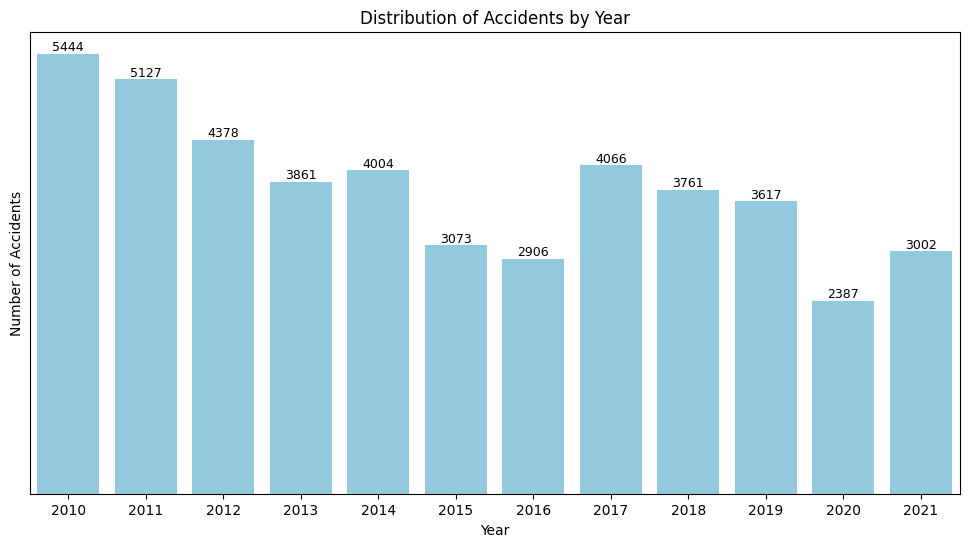

In [ ]:
countplot_distribution(df, x_column='Year', color='skyblue', x_ticks=range(9),
                        title='Distribution of Accidents by Year', x_label='Year')

Here are the take away points from the plot:
- The number of accidents generally decreases from 2010 (5444 accidents) to 2016 (2906 accidents).
- There is a noticeable increase in the number of accidents in 2017 (4066 accidents).
- After 2017, the number of accidents gradually decreases again until 2020, where it reaches a low of 2387 accidents.
- In 2021, there is a slight increase in the number of accidents (3002 accidents).
- There is a general trend of decreasing accidents over the years, with a few fluctuations, particularly a peak in 2017 and a low point in 2020.

### **Is there any observable trend in the severity of accidents over the years?**

In [ ]:
# Severity by Year
severity_by_year = df.groupby(["Year", "Severity"]).size().unstack()
severity_by_year

Severity,1,2,3
Year,,,
2010,53,647,4744
2011,73,631,4423
2012,46,611,3721
2013,33,581,3247
2014,52,631,3321
2015,48,557,2468
2016,51,564,2291
2017,50,688,3328
2018,50,649,3062


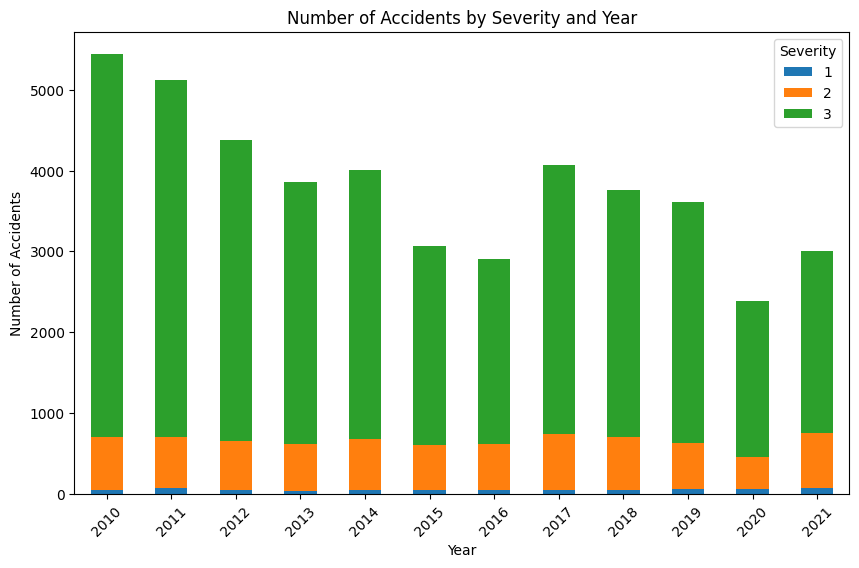

In [ ]:
# Plot of Severity by Year
severity_by_year.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Accidents by Severity and Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.show()

The plot shows the number of accidents by severity (1, 2, and 3) for each year from 2010 to 2021:

- Most accidents each year are of severity 3 (green).
- Accidents of all severities generally decreased over the period.
- Peaks in total accidents are visible in 2010 and 2017.
- A significant drop in total accidents occurred in 2020, with a slight rise in 2021.
- Accidents are predominantly of severity 3, with a decreasing trend over the years and noticeable fluctuations in certain years.

## 2. Vehicle and Casualties
### **What is the distribution of the number of vehicles involved in accidents?**

In [ ]:
# Vehicle Distribution
vehicle_distribution = df["NumberVehicles"].value_counts()
vehicle_distribution

NumberVehicles
2     28335
1     12419
3      3773
4       789
5       189
6        79
7        16
8         8
9         6
10        4
11        4
19        1
12        1
13        1
16        1
Name: count, dtype: int64

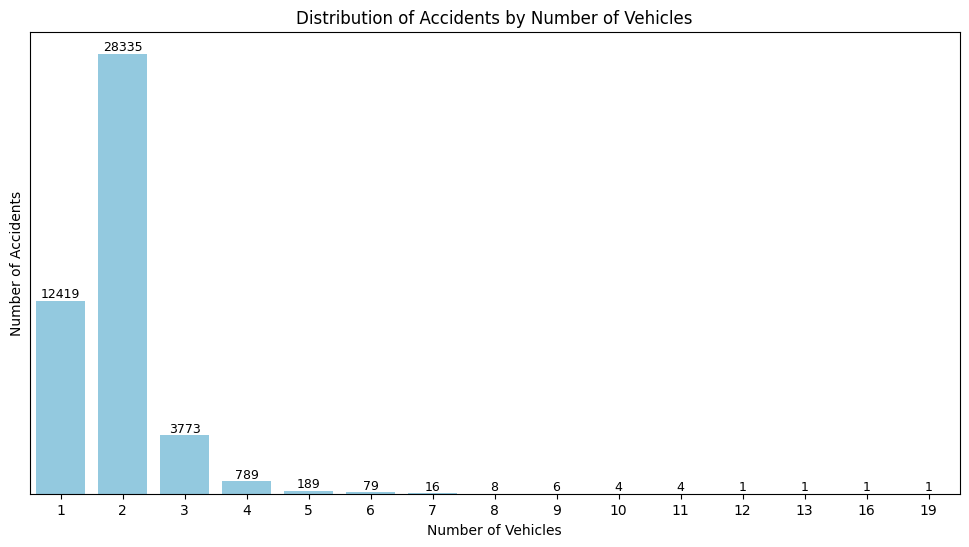

In [ ]:
countplot_distribution(df, x_column='NumberVehicles', color='skyblue', x_ticks=range(15),
                        title='Distribution of Accidents by Number of Vehicles', x_label='Number of Vehicles')

The plot shows the distribution of accidents by the number of vehicles involved:

- The majority of accidents involve 2 vehicles (28,335 accidents).
- Single-vehicle accidents are also common (12,419 accidents).
- Accidents involving 3 vehicles are less frequent (3,773 accidents).
- Accidents involving 4 or more vehicles are rare, with numbers decreasing as the number of vehicles increases.
- Most accidents involve either 1 or 2 vehicles, with a steep drop in frequency for accidents involving more vehicles.

### **What is the distribution of the number of casualties per accident?**

In [ ]:
# Casualties Distribution
casualties_distribution = df["NumberCasualties"].value_counts()
casualties_distribution

NumberCasualties
1     35029
2      6865
3      2230
4       941
5       317
6       141
7        51
8        18
9        13
10        7
13        4
19        2
12        2
11        2
87        1
29        1
14        1
17        1
Name: count, dtype: int64

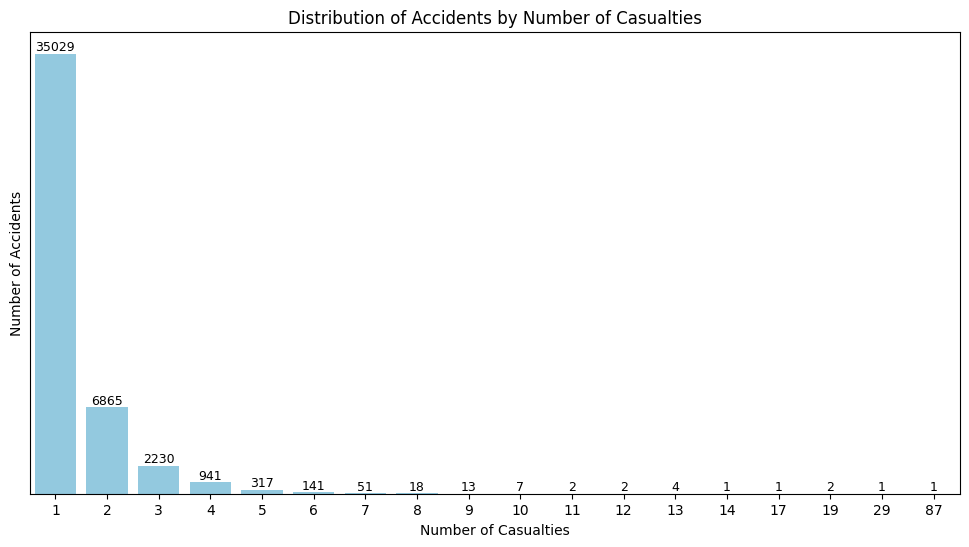

In [ ]:
countplot_distribution(df, x_column='NumberCasualties', color='skyblue', x_ticks=range(15),
                        title='Distribution of Accidents by Number of Casualties', x_label='Number of Casualties')

- 35029 incidents have been reported when there is just one injury. This is the majority of accidents. There are, nonetheless, other incidents with greater death tolls, such as 6865 incidents with two fatalities.

## 3. Temporal Analysis
### **Is there any particular day of the week when accidents are more likely to occur?**

In [ ]:
# Accidents by day of the week
accidents_by_day = df["Day"].value_counts()
accidents_by_day

Day
6    7355
5    6969
3    6866
4    6815
2    6478
7    6092
1    5051
Name: count, dtype: int64

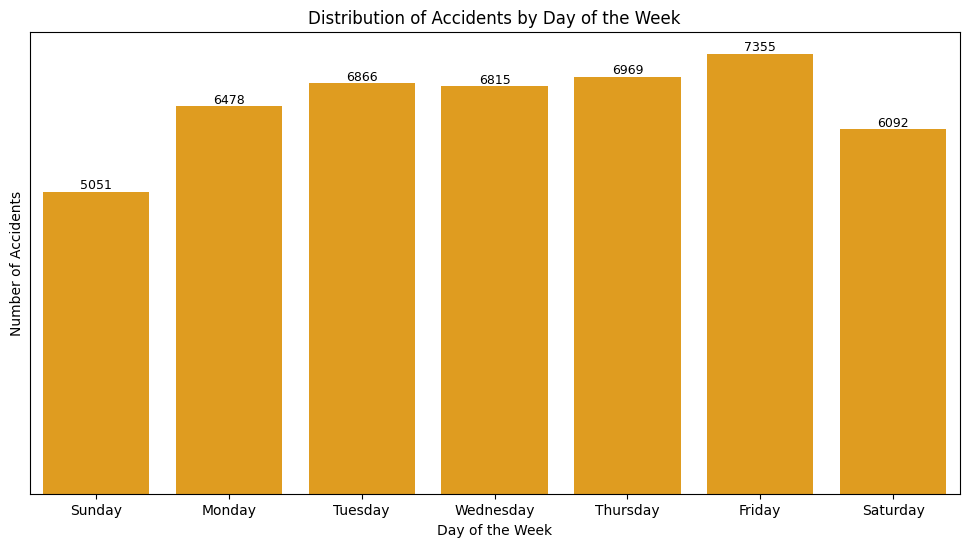

In [ ]:
# Calling the function to plot the distribution of accidents by day of the week
countplot_distribution(df, x_column='Day', color='orange', x_ticks=range(7),
                        x_tick_labels=days, title='Distribution of Accidents by Day of the Week',
                        x_label='Day of the Week')

- Based on a day-by-day analysis of the data, we find that Fridays and Thursdays had the largest number of accidents — 7355 and 6969, respectively. There are 5051 recorded incidents on Sundays, which is the least number of accidents.

### **At what time of the day do most accidents occur?**

In [ ]:
# Accidents by time
accidents_by_time = df["OutputTime"].value_counts()
accidents_by_time

OutputTime
17:00    484
17:30    457
15:30    444
18:00    419
16:00    411
        ... 
04:51      1
03:14      1
04:41      1
00:00      1
04:21      1
Name: count, Length: 1413, dtype: int64

In [ ]:
# Accidents by hour of the day
accidents_by_hour = df["hour"].value_counts()
accidents_by_hour

hour
17    4254
15    3874
16    3852
18    3556
8     3093
14    2713
13    2628
19    2601
12    2425
11    2123
9     2102
20    1865
10    1832
7     1655
21    1407
22    1315
23     930
6      729
0      703
1      524
2      431
3      372
5      359
4      283
Name: count, dtype: int64

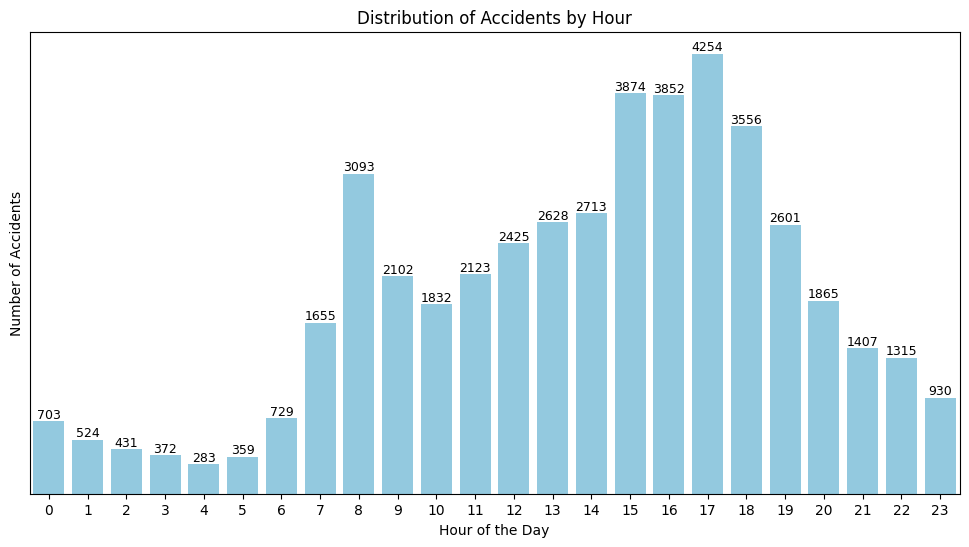

In [ ]:
# Calling the function to plot the distribution of accidents by hour
countplot_distribution(df, x_column='hour', color='skyblue', x_ticks=range(0, 24),
                        title='Distribution of Accidents by Hour', x_label='Hour of the Day')

- Based on a time-of-day examination of incidents, 4254 accidents were recorded between 5:00 PM and 6:00 PM, which is when most accidents happen. Accidents that happen between 4:00 and 5:00 PM and between 3:00 and 4:00 PM come next in close succession.

## 4. Road Type Analysis
### **Is there any correlation between accidents and the type of road (Road1Class, CarriagewayType, etc.)?**

In [ ]:
# Accidents by Carriageway Type
accidents_by_carriageway_type = df.groupby("CarriagewayType").size()
accidents_by_carriageway_type

CarriagewayType
1     2075
2      956
3     7952
6    33894
7      360
9      389
dtype: int64

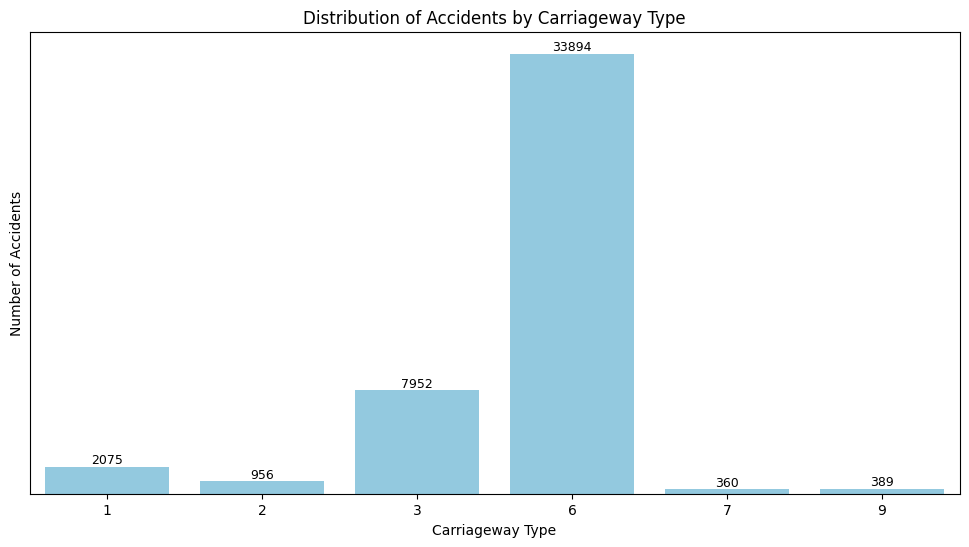

In [ ]:
countplot_distribution(df, x_column='CarriagewayType', color='skyblue', x_ticks=range(9),
                        title='Distribution of Accidents by Carriageway Type', x_label='Carriageway Type')

- Accidents are more common on “single carriageway” than on other sorts of roads, according to an analysis of the type of road and its relationship to accidents.

## 5. Environmental Factors
### **Do accidents occur more often in certain weather conditions or lighting conditions?**

In [ ]:
# Accidents by Weather Condition
accidents_by_weather = df.groupby("WeatherCondition").size()
accidents_by_weather

WeatherCondition
1    34978
2     6381
3      259
4      425
5      729
6       68
7      105
8      964
9     1717
dtype: int64

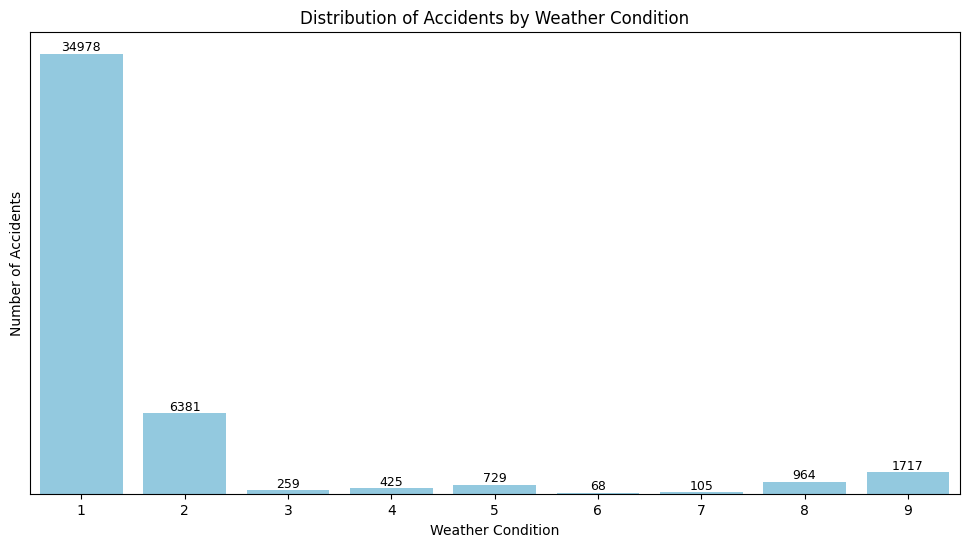

In [ ]:
countplot_distribution(df, x_column='WeatherCondition', color='skyblue', x_ticks=range(9),
                        title='Distribution of Accidents by Weather Condition', x_label='Weather Condition')

- Certain types of weather are more likely to cause accidents. There have been 34978 recorded accidents, the majority of which happen in “fine without high winds” weather. Significantly more accidents occur when there are additional weather conditions, such as “raining without high winds,” “other,” and “unknown.”

In [ ]:
# Accidents by Lighting Condition
accidents_by_lighting = df.groupby("LightingCondition").size()
accidents_by_lighting

LightingCondition
1    26301
2     4115
3     1584
4    11829
5      220
6      351
7     1226
dtype: int64

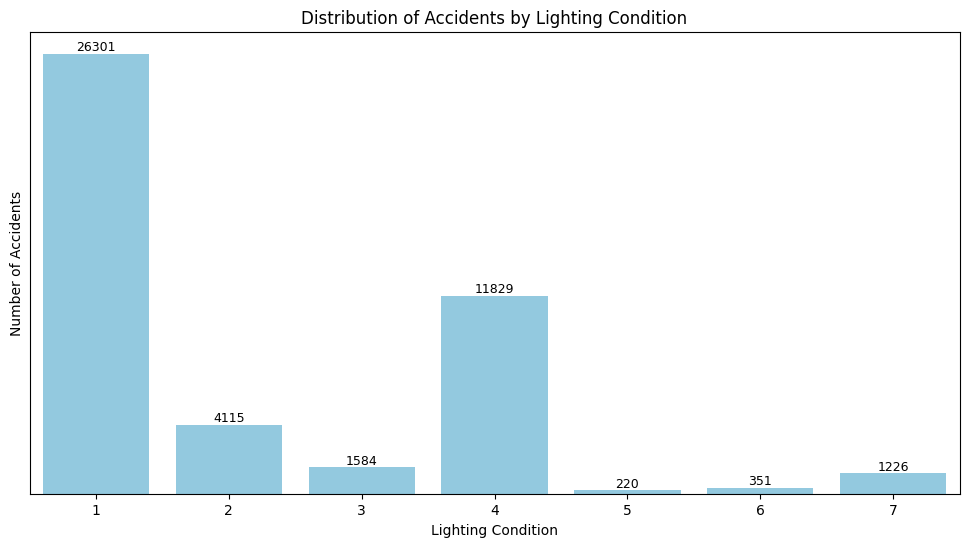

In [ ]:
countplot_distribution(df, x_column='LightingCondition', color='skyblue', x_ticks=range(7),
                        title='Distribution of Accidents by Lighting Condition', x_label='Lighting Condition')

- With 26301 incidents recorded, “daylight — lights present” circumstances (lighting condition code 1) account for the bulk of accidents. But accidents can also happen when it’s “darkness — lights lit conditions” (lighting condition code 4).

### **How does the road surface condition affect the frequency and severity of accidents?**

In [ ]:
# Accidents by Road Surface Type
accidents_by_road_surface = df.groupby("RoadSurface").size()
accidents_by_road_surface

RoadSurface
1    31400
2    13394
3      237
4      561
5       34
dtype: int64

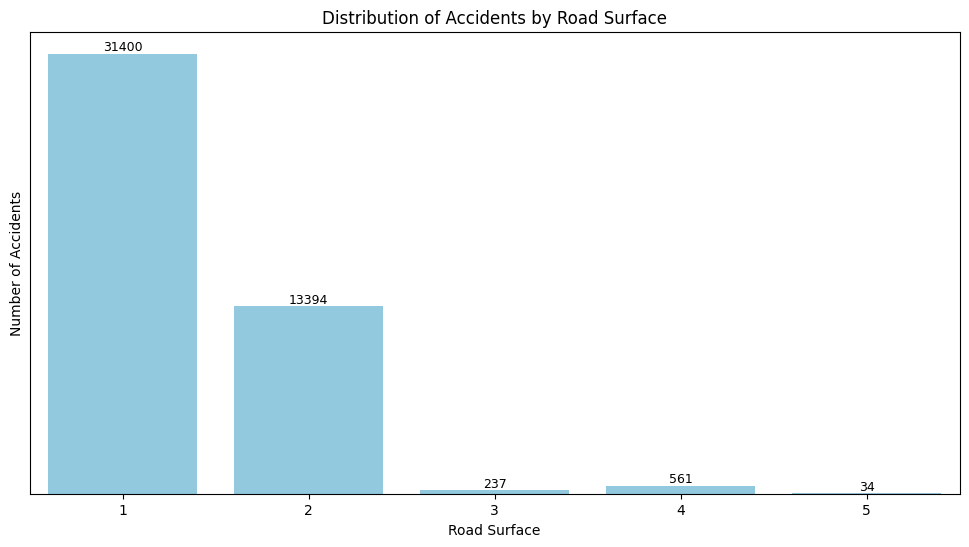

In [ ]:
countplot_distribution(df, x_column='RoadSurface', color='skyblue', x_ticks=range(5),
                        title='Distribution of Accidents by Road Surface', x_label='Road Surface')

In [ ]:
# Accident by Severity and Road Surface
severity_by_RoadSurface = df.groupby(["RoadSurface", "Severity"]).size().unstack()
severity_by_RoadSurface

Severity,1,2,3
RoadSurface,,,
1,433,5080,25887
2,201,2022,11171
3,5,21,211
4,9,74,478
5,1,4,29


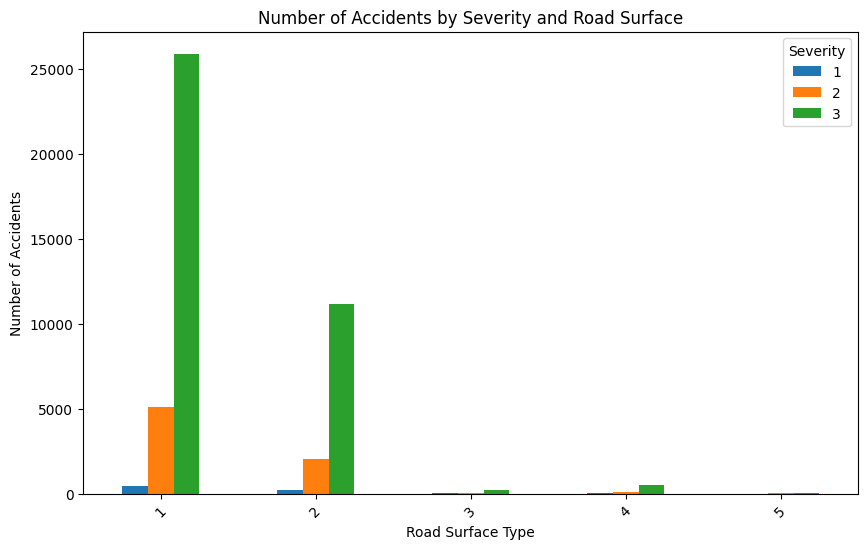

In [ ]:
# Plot of Severity by Year
severity_by_RoadSurface.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Number of Accidents by Severity and Road Surface')
plt.xlabel('Road Surface Type')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.show()

- The frequency and severity of accidents seem to be influenced by the state of the road surface. The biggest frequency of accidents occurs on roads with dry road surface condition (excellent), but they also occur more frequently on roads with minor severity.

## 6. Special Conditions and Hazards
### **What are the most common special conditions and carriageway hazards associated with accidents?**

In [ ]:
# Accidents by Special Conditions
accidents_by_special_conditions = df.groupby("SpecialConditions").size()
accidents_by_special_conditions

SpecialConditions
0    44594
1       75
2       12
3      161
4      608
5       71
6       82
7       23
dtype: int64

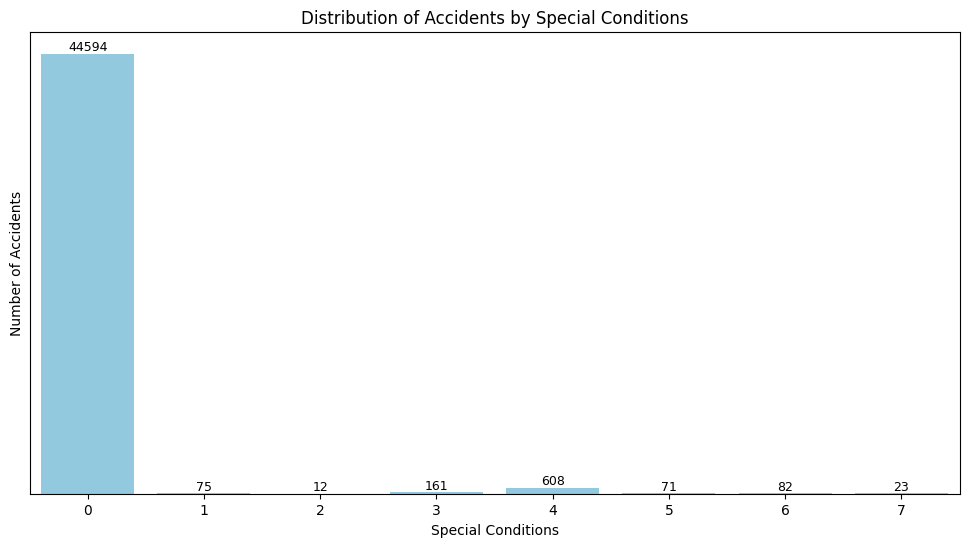

In [ ]:
countplot_distribution(df, x_column='SpecialConditions', color='skyblue', x_ticks=range(8),
                        title='Distribution of Accidents by Special Conditions', x_label='Special Conditions')

- The majority of accidents (44594) occur under no special condition at site. Nonetheless, some circumstances, such as “permanent road signage” or “defective or obscured markings,” “roadworks,” and “oil and diesel,” might also result in accident reports.

In [ ]:
# Accidents by carriageway Hazard
accidents_by_carriageway_hazard = df.groupby("CarriagewayHazard").size()
accidents_by_carriageway_hazard

CarriagewayHazard
0    45184
1       39
2      248
3       44
6       67
7       44
dtype: int64

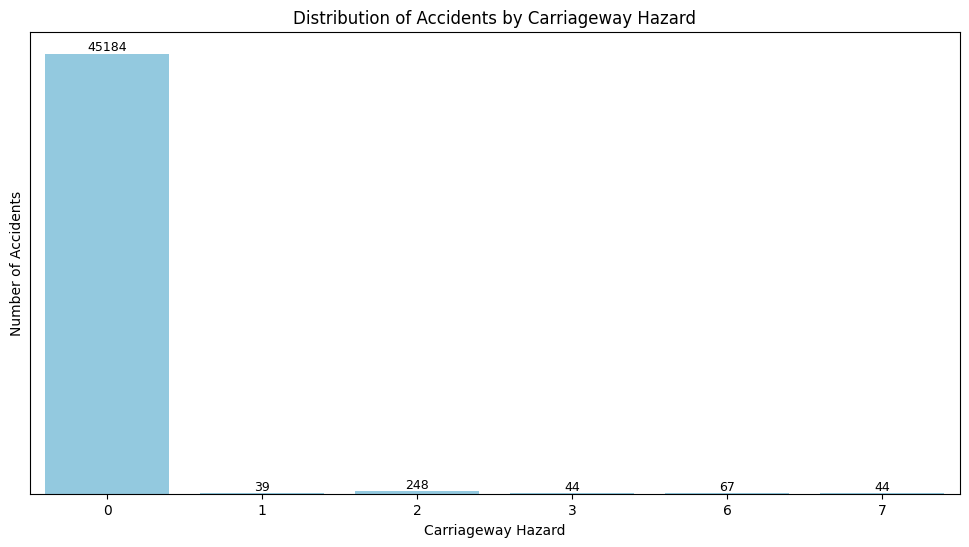

In [ ]:
countplot_distribution(df, x_column='CarriagewayHazard', color='skyblue', x_ticks=range(6),
                        title='Distribution of Accidents by Carriageway Hazard', x_label='Carriageway Hazard')

- When there are no particular road risks, most accidents take place. The presence of “other object in carriageway” (code 2) and “involvement with previous accident” (code 3) are examples of dangerous situations that can also result in accidents.

### **Is there a correlation between the presence of pedestrian crossings and the number of accidents?**

In [ ]:
# Accidents by Pedestrian Crossing
accidents_by_ped_crossing = df.groupby("PedCrossingPhysicalFacilities").size()
accidents_by_ped_crossing

PedCrossingPhysicalFacilities
0    34383
1      610
4     2332
5     6806
7      110
8     1385
dtype: int64

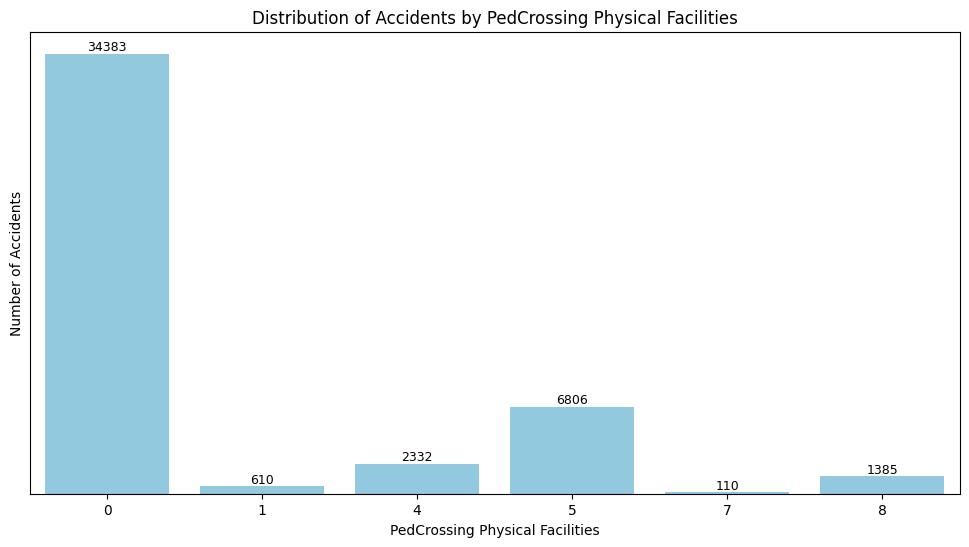

In [ ]:
countplot_distribution(df, x_column='PedCrossingPhysicalFacilities', color='skyblue', x_ticks=range(6),
                        title='Distribution of Accidents by PedCrossing Physical Facilities', x_label='PedCrossing Physical Facilities')

- There are more accidents in places where there is “no physical crossing facility within 50m.” But at “pedestrian phase at traffic signal junction,” there are also high accident rates.

### 7. Severity Analysis
### **What factors contribute most to severe accidents?**

In [ ]:
# Accidents by Speed Limit
accidents_by_speed_limit = df.groupby("SpeedLimit").size()
accidents_by_speed_limit

SpeedLimit
20     2583
30    36159
40     3049
50      877
60      390
70     2568
dtype: int64

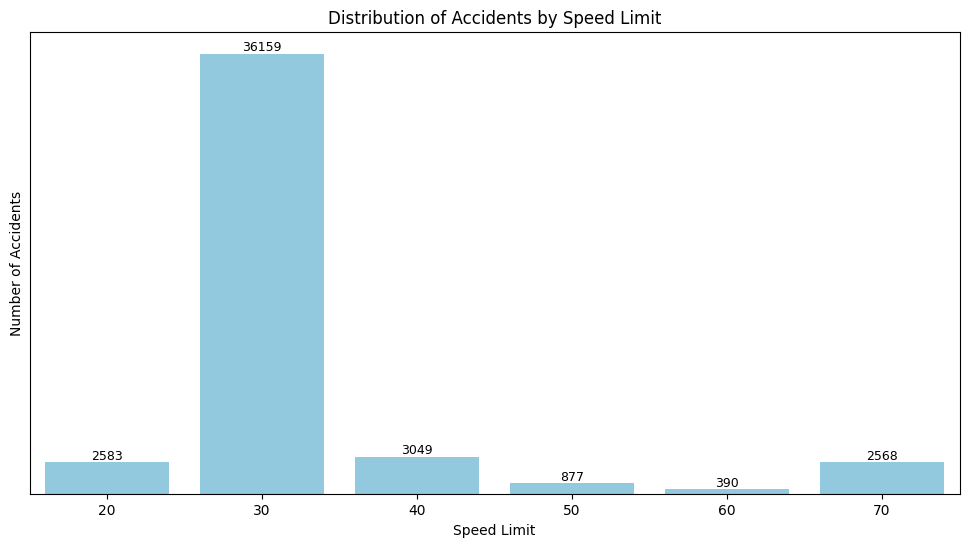

In [ ]:
countplot_distribution(df, x_column='SpeedLimit', color='skyblue', x_ticks=range(3),
                        title='Distribution of Accidents by Speed Limit', x_label='Speed Limit')

- Most accidents occur in areas with a 30 mph speed limit (36,159 accidents), followed by 20 mph (2,583 accidents) and 40 mph (3,049 accidents). Fewer accidents occur at higher speed limits: 50 mph (877 accidents), 60 mph (390 accidents), and 70 mph (2,568 accidents).

In [ ]:
# Accident by Severity
accidents_by_severity = df['Severity'].value_counts()
accidents_by_severity

Severity
3    37776
2     7201
1      649
Name: count, dtype: int64

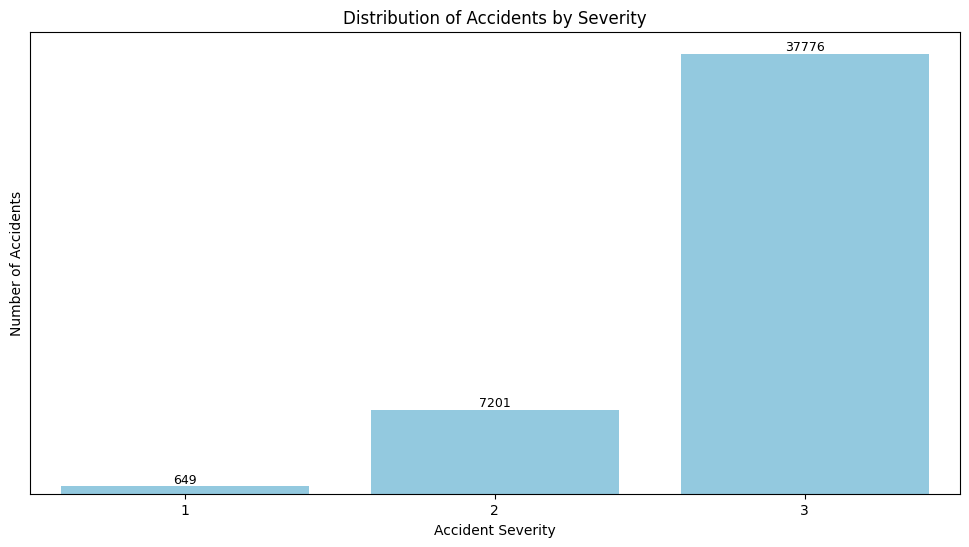

In [ ]:
countplot_distribution(df, x_column='Severity', color='skyblue', x_ticks=range(3),
                        title='Distribution of Accidents by Severity', x_label='Accident Severity')

- Most accidents are of severity 3 (slight) (37,776 accidents), followed by severity 2 (serious) (7,201 accidents) and severity 1 (fatal) (649 accidents).

### **How do road speed limits affect the severity of accidents?**

In [ ]:
# Accident by Severity and Speed Limit
severity_by_SpeedLimit = df.groupby(["SpeedLimit", "Severity"]).size().unstack()
severity_by_SpeedLimit

Severity,1,2,3
SpeedLimit,,,
20,29,422,2132
30,469,5733,29957
40,53,531,2465
50,30,141,706
60,17,100,273
70,51,274,2243


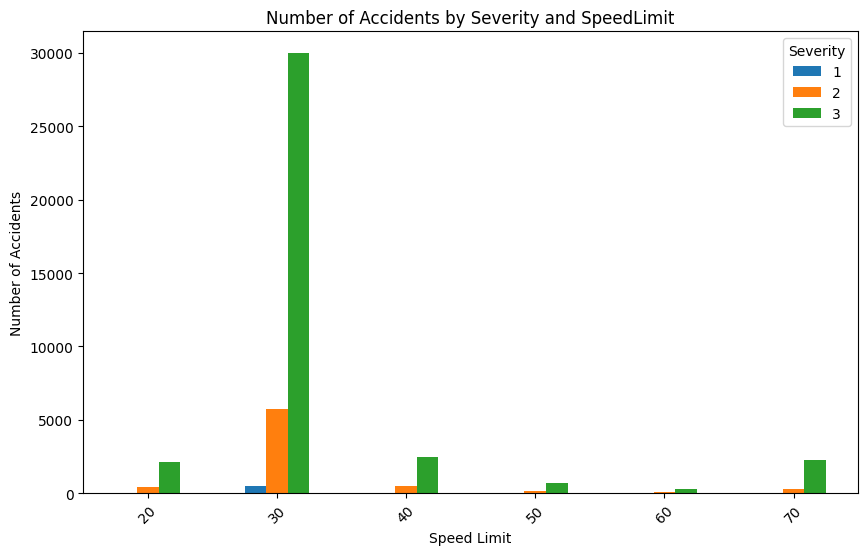

In [ ]:
# Plot of Severity by Year
severity_by_SpeedLimit.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Number of Accidents by Severity and SpeedLimit')
plt.xlabel('Speed Limit')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.show()

- The difference in road speed restrictions affects the severity of accidents. Roads with 30 mph speed restrictions see most accidents, however they are often more serious incidents.

## 8. Local Authority Analysis
### **Is there a difference in accident rates between different local authorities within Greater Manchester?**
### **Do certain local authorities have better safety records than others?**


In [ ]:
# Accidents by Local Authority
accidents_by_local_authority = df.groupby("LocalAuthority").size()
accidents_by_local_authority

LocalAuthority
100     5130
101     2997
102    11627
104     3859
106     3379
107     4418
109     3657
110     3202
112     3395
114     3962
dtype: int64

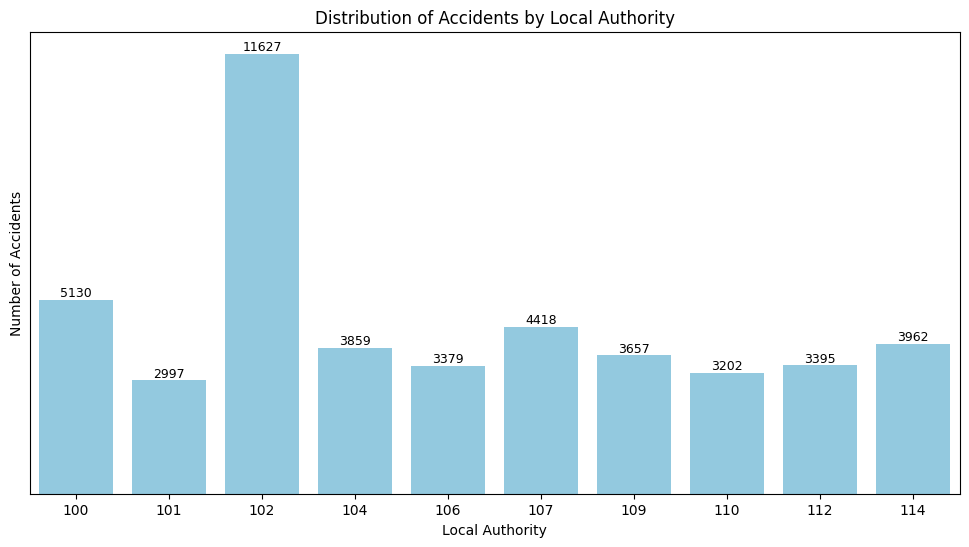

In [ ]:
countplot_distribution(df, x_column='LocalAuthority', color='skyblue', x_ticks=range(10),
                        title='Distribution of Accidents by Local Authority', x_label='Local Authority')

- Within Greater Manchester, the rates of accidents vary between local administrations. There are local authorities such as Bury, Tameside, and Rochdale with superior safety records and others with greater accident rates, such as Manchester, Bolton, and Salford.

## Data Modelling
Since the original data came with all the categorical variables encoded, and also has no null values, the data modelling will be done. The target variable in this case is Severity. Our goal is to predict the severity of accidents based on some variables.

In [ ]:
# Selecting all numerical variables
numerical_variables = df.select_dtypes(include='number')

### Correlation Matrix
Correlation matrix will be plotted to visually identify the strength and direction of relationships between variables. It will also help in detecting multicollinearity among the predictor variables.

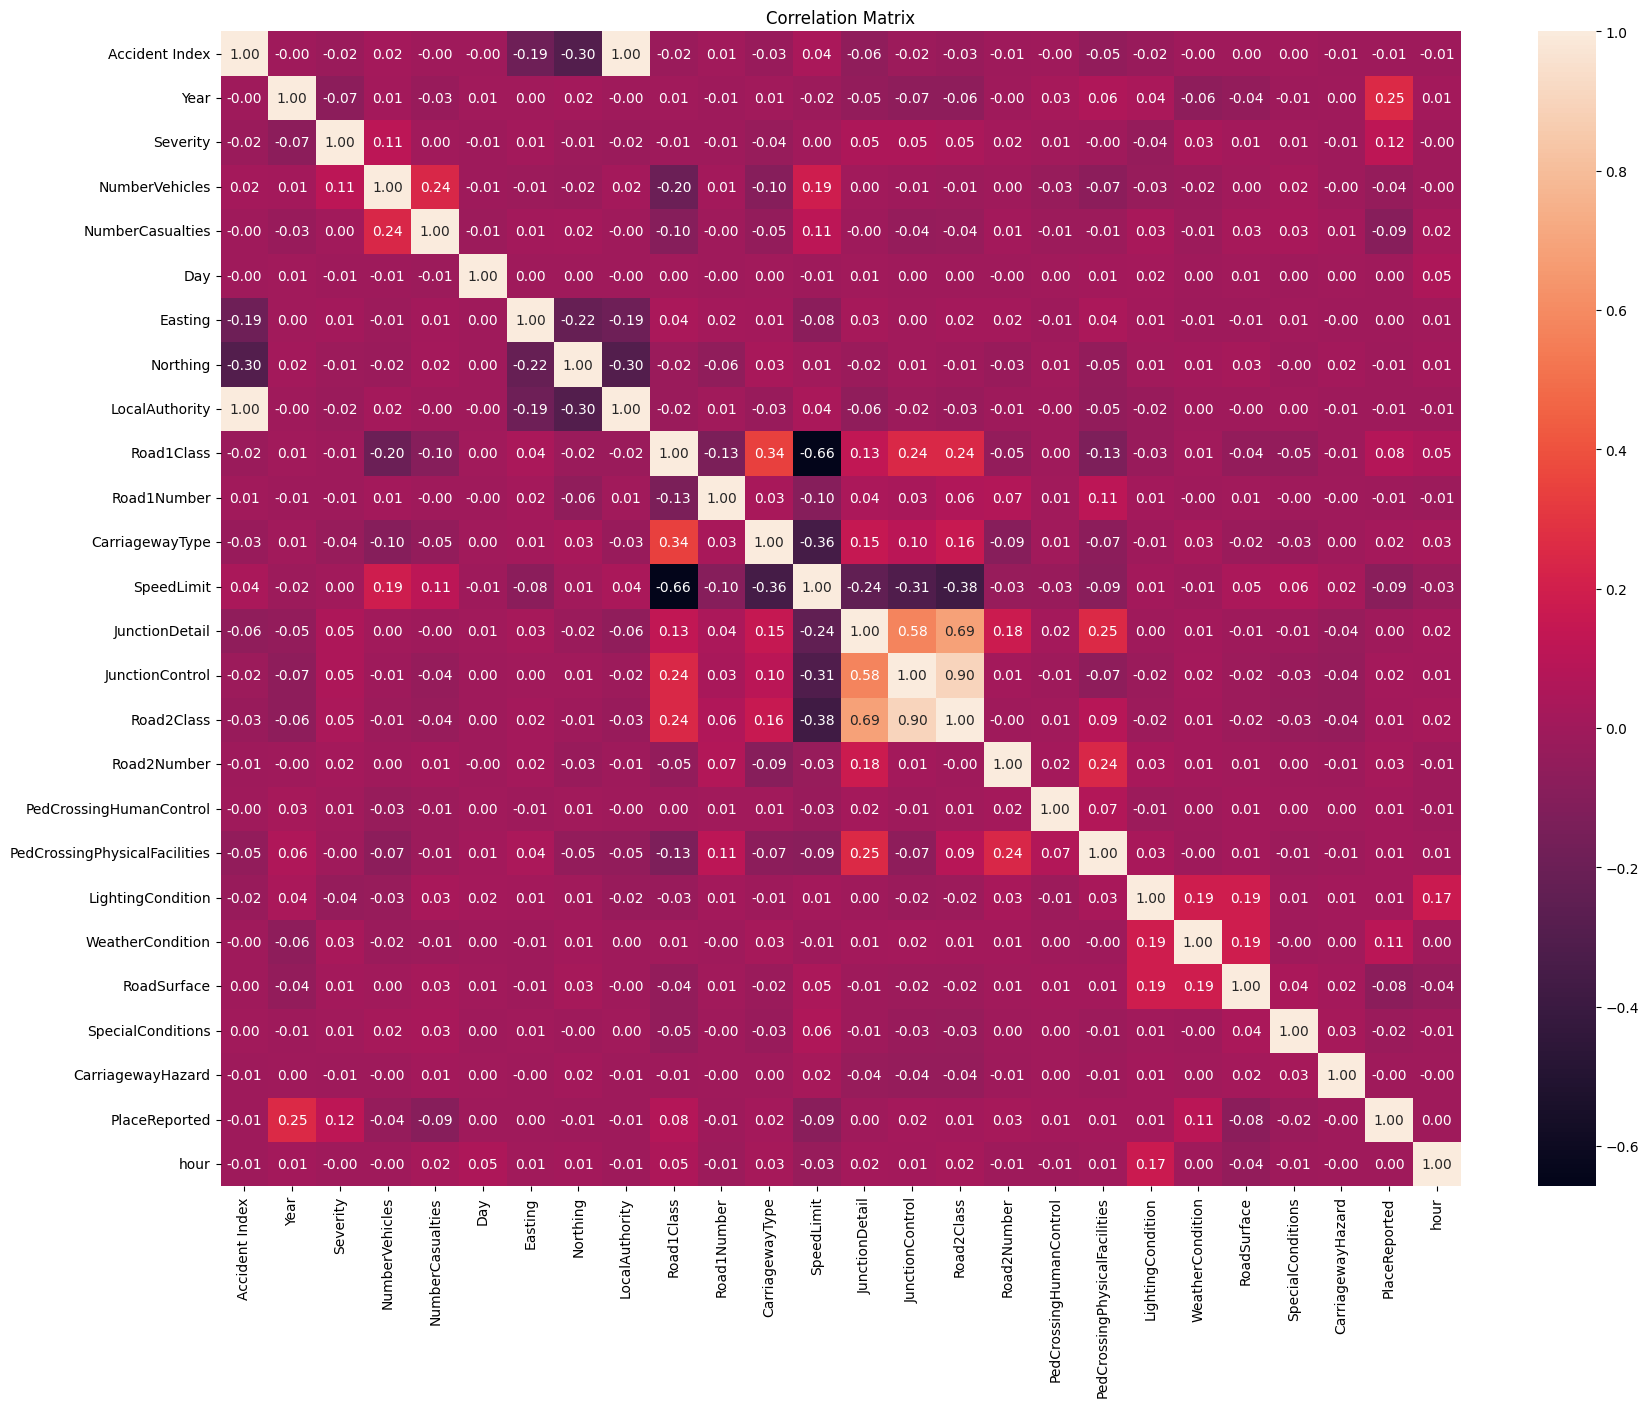

In [ ]:
# Correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(numerical_variables.corr(), annot=True, fmt=".2f");
plt.title('Correlation Matrix')
plt.show()

- Generally, there are no strong positive relationships between the predictor variables except for JunctionDetail, JunctionControl and Road2Class that have a substantial positive relationship with each other. Additionally, there are weak relationships between the target variable and the predictor variables. For the purpose of this project, the junctionDetail, JunctionControl and Road2Class will be retained as part of the predictor variables while other irrelevant variables will be dropped.

In [ ]:
# Split data into features and target variable
X = df.drop(['Accident Index', 'OutputDate', 'OutputTime', 'Easting', 'Northing', 'Severity'], axis=1) # Drop irrelevant columns

y = df['Severity']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Model Evaluation
y_pred = model.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.20      0.01      0.01       192
           2       0.32      0.03      0.05      2164
           3       0.83      0.99      0.90     11332

    accuracy                           0.82     13688
   macro avg       0.45      0.34      0.32     13688
weighted avg       0.74      0.82      0.76     13688

Confusion Matrix:
 [[    1     7   184]
 [    2    64  2098]
 [    2   129 11201]]


- The model did not perform well especially for the minority class. This is not far fetched as the training data is highly imbalanced. The imbalanced nature of the dataset also informs our choice of accuracy, precision, recall and f1-score as the evaluation metrics for the models. Precision is crucial to reduce false positives, especially in minority classes like serious and fatal classes. Recall ensures that the model captures most of the relevant instances, reducing false negatives while the f1-score balances the performance across all classes, ensuring that the evaluation does not overly favour the majority class (slight).

## Hyperparameter Tuning using GridSearchCV
GridSearchCV will be employed below as a model improvement measure. The grid search will perform 3-fold cross-validation

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Create the model
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
# Create GridSearchCV object
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the GridSearchCV object to the data
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Model with best parameters
best_model = grid_search.best_estimator_

In [ ]:
# Model Evaluation
y_pred = best_model.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       192
           2       0.43      0.00      0.01      2164
           3       0.83      1.00      0.91     11332

    accuracy                           0.83     13688
   macro avg       0.42      0.33      0.30     13688
weighted avg       0.75      0.83      0.75     13688

Confusion Matrix:
 [[    0     2   190]
 [    0     9  2155]
 [    0    10 11322]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- The model still performed poorly in the minority classes. In future experiments, data balancing techniques such as SMOTE will be employed as a model improvement measure.